In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import logging
import argparse
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
import tensorflow as tf

import seaborn as sns
sns.set_context('notebook')

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [6]:
predictions_loc = 'gz_decals_auto_posteriors.parquet'
df = pd.read_parquet(predictions_loc)

In [7]:
df['file_loc'].sample(20)

3719      dr5/png/J084/J084930.47+080615.0.png
191067    dr5/png/J005/J005512.27-003831.1.png
230297    dr5/png/J135/J135706.09-064039.0.png
281347    dr5/png/J131/J131428.58+032222.0.png
340677    dr5/png/J102/J102924.47+154941.6.png
37197     dr5/png/J104/J104026.10+240507.6.png
47585     dr5/png/J225/J225253.40-055634.9.png
236254    dr5/png/J015/J015748.19-083544.0.png
152758    dr5/png/J124/J124524.82-045848.0.png
340060    dr5/png/J102/J102645.97+315756.1.png
88868     dr5/png/J095/J095853.66-003339.3.png
198181    dr5/png/J232/J232015.45+000340.2.png
212927    dr5/png/J134/J134814.18+153126.7.png
268420    dr5/png/J130/J130404.14+191741.8.png
337100    dr5/png/J102/J102355.74+065452.7.png
94346     dr5/png/J154/J154425.06+091254.0.png
145172    dr5/png/J090/J090716.01+154536.9.png
277718    dr5/png/J010/J010031.90+154217.2.png
237852    dr5/png/J015/J015416.09-061744.0.png
1608      dr5/png/J084/J084131.06+265054.0.png
Name: file_loc, dtype: object

In [61]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=5, nrows=3, ncols=6, max_g=99):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, 0.25 * scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'].replace('dr5/png', '/media/walml/beta1/decals/png_native/dr5').replace('dr1_dr2', '/media/walml/beta1/galaxy_zoo/decals/dr1_dr2'))
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
        if galaxy_n >= max_g:
            break
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


<Figure size 432x288 with 0 Axes>

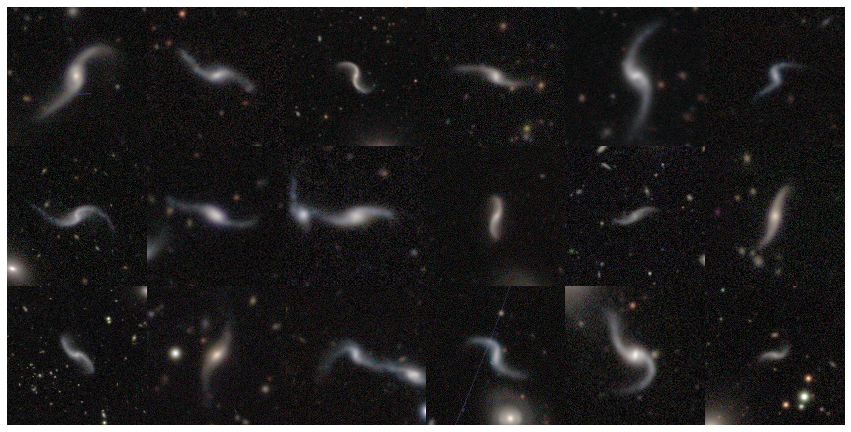

In [62]:
_ = show_galaxies(df.sort_values('spiral-winding_loose_fraction', ascending=False))
# plt.savefig('ml_top_n_spiral-winding_loose.png')
# plt.savefig('ml_top_n_spiral-winding_loose.jpg')

In [ ]:
_ = show_galaxies(df.sort_values('bar_strong_fraction', ascending=False))
# plt.savefig('ml_top_n_bar_strong.png')
# plt.savefig('ml_top_n_bar_strong.jpg')

In [ ]:
_ = show_galaxies(df.sort_values('edge-on-bulge_none_fraction', ascending=False))
# plt.savefig('ml_top_n_edge-on-bulge_none.png')
# plt.savefig('ml_top_n_edge-on-bulge_none.jpg')

In [ ]:
_ = show_galaxies(df.sort_values('spiral-arm-count_1_fraction', ascending=False))
# plt.savefig('ml_top_n_spiral-arm-count_1.png')
# plt.savefig('ml_top_n_spiral-arm-count_1.jpg')

<Figure size 432x288 with 0 Axes>

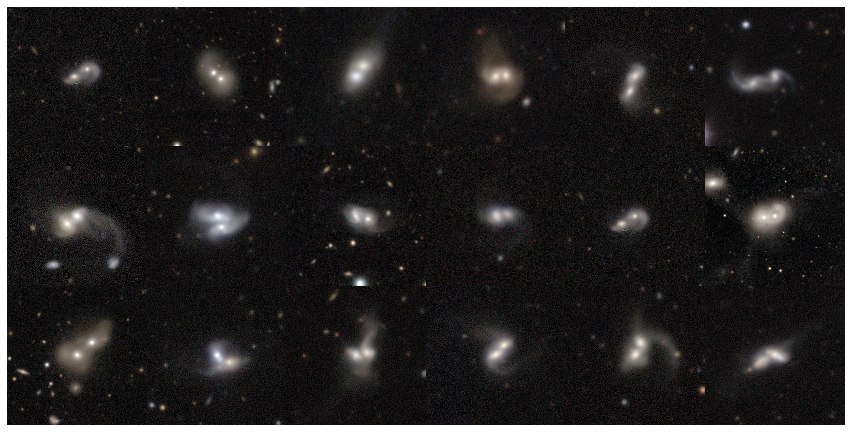

In [63]:
_ = show_galaxies(df.sort_values('merging_merger_fraction', ascending=False), max_g=15)
# plt.tight_layout()
# plt.savefig('thesis_ml_top_n_merging_merger.png')
# plt.savefig('thesis_ml_top_n_merging_merger.jpg')

In [25]:
df.columns.values

array(['iauname', 'smooth-or-featured_smooth_concentration',
       'smooth-or-featured_featured-or-disk_concentration',
       'smooth-or-featured_artifact_concentration',
       'disk-edge-on_yes_concentration', 'disk-edge-on_no_concentration',
       'has-spiral-arms_yes_concentration',
       'has-spiral-arms_no_concentration', 'bar_strong_concentration',
       'bar_weak_concentration', 'bar_no_concentration',
       'bulge-size_dominant_concentration',
       'bulge-size_large_concentration',
       'bulge-size_moderate_concentration',
       'bulge-size_small_concentration', 'bulge-size_none_concentration',
       'how-rounded_round_concentration',
       'how-rounded_in-between_concentration',
       'how-rounded_cigar-shaped_concentration',
       'edge-on-bulge_boxy_concentration',
       'edge-on-bulge_none_concentration',
       'edge-on-bulge_rounded_concentration',
       'spiral-winding_tight_concentration',
       'spiral-winding_medium_concentration',
       'spiral-wi

In [27]:
df_feat = df[(df['disk-edge-on_no_fraction'] > 0.5) & (df['smooth-or-featured_featured-or-disk_fraction'] > 0.5)]

In [33]:
df_spiral = df_feat[df_feat['has-spiral-arms_yes_fraction'] > 0.5]

In [36]:
num_per = 6
df_s = pd.concat([
    df_spiral.sort_values('spiral-arm-count_1_fraction', ascending=False)[:num_per],
    df_spiral.sort_values('spiral-arm-count_2_fraction', ascending=False)[:num_per],
    df_spiral.sort_values('spiral-arm-count_3_fraction', ascending=False)[:num_per],
    df_spiral.sort_values('spiral-arm-count_4_fraction', ascending=False)[:num_per],
    df_spiral.sort_values('spiral-arm-count_more-than-4_fraction', ascending=False)[:num_per]
#     df_spiral.sort_values('spiral-arm-count_cant-tell_fraction', ascending=False)[:num_per]
])

IndexError: single positional indexer is out-of-bounds

<Figure size 432x288 with 0 Axes>

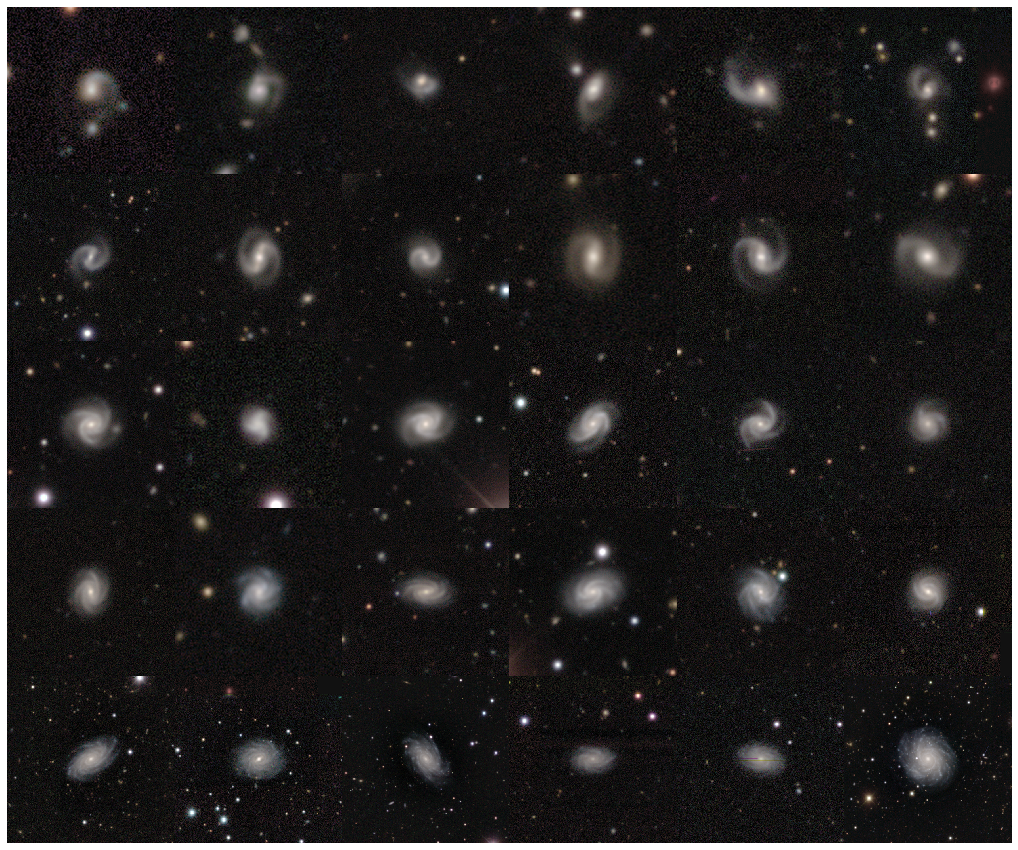

In [37]:
_ = show_galaxies(df_s)

In [38]:
num_per = 6
df_w = pd.concat([
    df_spiral.sort_values('spiral-winding_loose_fraction', ascending=False)[:num_per],
    df_spiral.sort_values('spiral-winding_medium_fraction', ascending=False)[:num_per],
    df_spiral.sort_values('spiral-winding_tight_fraction', ascending=False)[:num_per]
])

<Figure size 432x288 with 0 Axes>

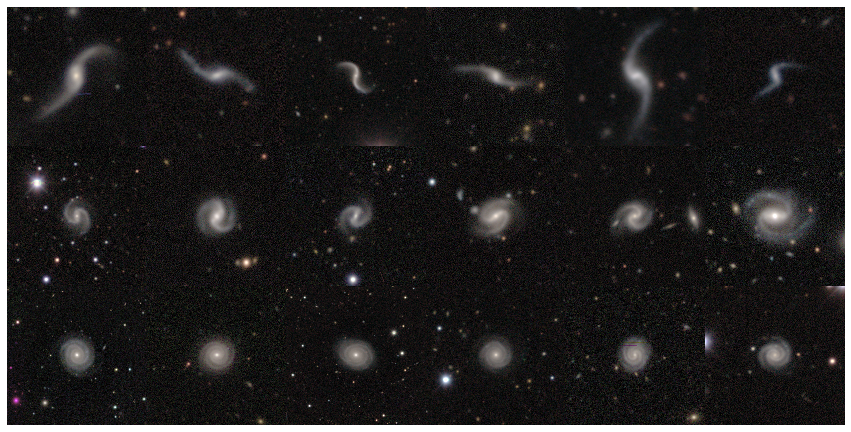

In [64]:
_ = show_galaxies(df_w, nrows=3, max_g=15)
# plt.savefig('thesis_ml_top_n_2spiral.png')
# plt.savefig('thesis_ml_top_n_2spiral.jpg')

In [40]:
df_2 = df_spiral[df_spiral['spiral-arm-count_2_fraction'] > 0.5]

num_per = 6
df_w2 = pd.concat([
    df_2.sort_values('spiral-winding_loose_fraction', ascending=False)[:num_per],
    df_2.sort_values('spiral-winding_medium_fraction', ascending=False)[:num_per],
    df_2.sort_values('spiral-winding_tight_fraction', ascending=False)[:num_per]
])

IndexError: single positional indexer is out-of-bounds

<Figure size 432x288 with 0 Axes>

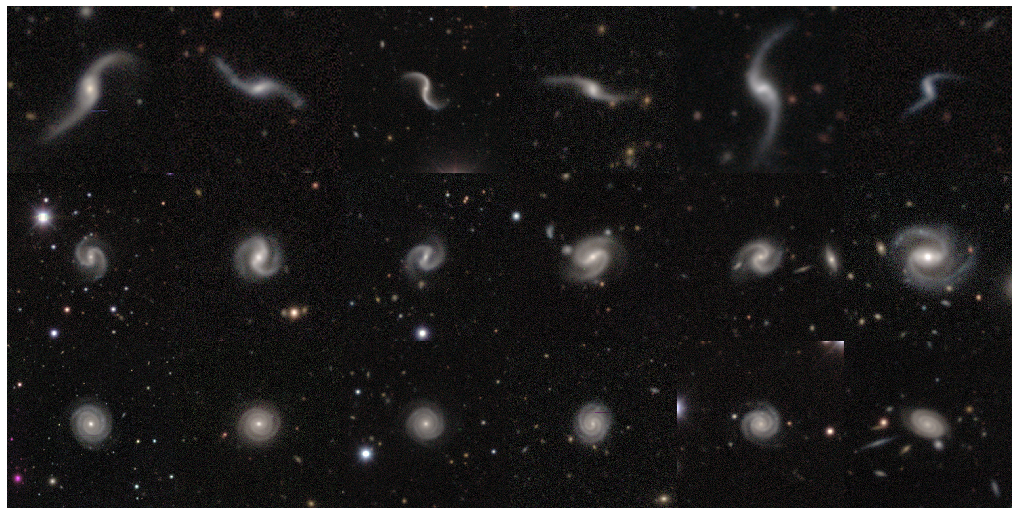

In [41]:
_ = show_galaxies(df_w2)

In [30]:
num_per = 6
df_b = pd.concat([
    df_feat.sort_values('bar_strong_fraction', ascending=False)[:num_per],
    df_feat.sort_values('bar_weak_fraction', ascending=False)[:num_per],
    df_feat.sort_values('bar_no_fraction', ascending=False)[:num_per]
])

IndexError: single positional indexer is out-of-bounds

<Figure size 432x288 with 0 Axes>

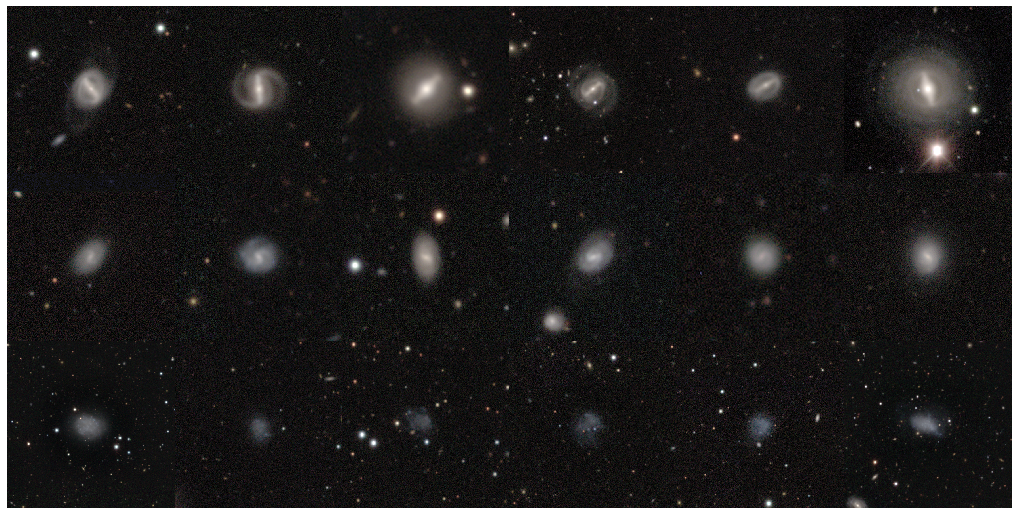

In [20]:
_ = show_galaxies(df_b)